<a href="https://colab.research.google.com/github/Ritwik-Bhaduri/Texture-Transfer-network/blob/master/Texture%20transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import numpy as np
import time
import functools
import PIL.Image
import IPython.display as display
import matplotlib.pyplot as plt

from google.colab import files
from PIL import Image  
import PIL

In [0]:
tf.__version__

'2.1.0-rc0'

To update tensorlow to current version:

In [0]:
!pip install tensorflow==2.1.0-rc0

In [0]:
tf.__version__

'2.1.0-rc0'

In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
def tensor_to_image(tensor):
    tensor = tf.clip_by_value(tensor, clip_value_min=0.0, clip_value_max=255.0)
    tensor = np.array(tensor, dtype=np.uint8)   # convert tf array to np array of integers
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1  # asserts that the BATCH_SIZE = 1
        tensor = tensor[0]   # take the first image
    return PIL.Image.fromarray(tensor)

In [0]:
def load_img(path_to_img, rescale = False):
    # we rescale the image to max dimension 256 for fasters processing
    max_dim = 256    
    img = tf.io.read_file(path_to_img)   # read the image
    img = tf.image.decode_image(img, channels=3)    # decode into image content
    img = tf.image.convert_image_dtype(img, tf.float32)    # convert to float
    
    if rescale:
        img = tf.image.resize(img, tf.constant([max_dim, max_dim]))
    else:
        shape = tf.cast(tf.shape(img)[:-1], tf.float32)   
        # get the shape of image, cast it to float type for division, expect the last channel dimension
        long_dim = max(shape)
        scale = max_dim / long_dim    # scale accordingly
        new_shape = tf.cast(shape * scale, tf.int32)   # cast the new shape to integer
        img = tf.image.resize(img, new_shape)   # resize image
        
    img = img[tf.newaxis, :]   # newaxis builts a new batch axis in the image at first dimension
    return img

In [0]:
! wget https://subroy13.github.io/post/post3/index_13_0.png
! wget https://subroy13.github.io/post/post3/index_15_0.png

--2020-01-14 06:57:36--  https://subroy13.github.io/post/post3/index_13_0.png
Resolving subroy13.github.io (subroy13.github.io)... 185.199.110.153, 185.199.109.153, 185.199.111.153, ...
Connecting to subroy13.github.io (subroy13.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97930 (96K) [image/png]
Saving to: ‘index_13_0.png’

index_13_0.png      100%[===================>]  95.63K  --.-KB/s    in 0.02s   

2020-01-14 06:57:36 (5.22 MB/s) - ‘index_13_0.png’ saved [97930/97930]

--2020-01-14 06:57:38--  https://subroy13.github.io/post/post3/index_15_0.png
Resolving subroy13.github.io (subroy13.github.io)... 185.199.110.153, 185.199.109.153, 185.199.111.153, ...
Connecting to subroy13.github.io (subroy13.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136807 (134K) [image/png]
Saving to: ‘index_15_0.png’

index_15_0.png      100%[===================>] 133.60K  --.-KB/s    in 0.02s   

In [0]:
style_path = 'index_15_0.png'
content_path = 'index_13_0.png'

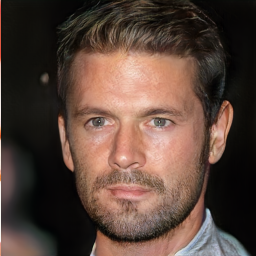

In [0]:
content_image = load_img(content_path, rescale = True)
tensor_to_image(content_image * 255.0)

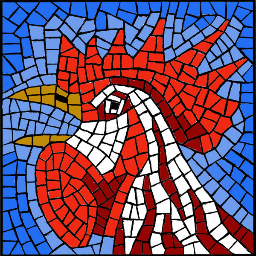

In [0]:
style_image = load_img(style_path, rescale = False)
tensor_to_image(style_image * 255.0)

In [0]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')   # Load VGG19 pretrained Network from Keras

print()
for layer in vgg.layers:
    print(layer.name)   # print layer names so that we can reference them later

80142336/80134624 [==============================] - 2s 0us/step

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
def periodic_padding(x, padding=1):
    '''
    x: shape (batch_size, d1, d2)
    return x padded with periodic boundaries. i.e. torus or donut
    '''
    d1 = x.shape[1] # dimension 1: height
    d2 = x.shape[2] # dimension 2: width
    p = padding
    # assemble padded x from slices
    #            tl,tc,tr
    # padded_x = ml,mc,mr
    #            bl,bc,br
    top_left = x[:, -p:, -p:] # top left
    top_center = x[:, -p:, :] # top center
    top_right = x[:, -p:, :p] # top right
    middle_left = x[:, :, -p:] # middle left
    middle_center = x # middle center
    middle_right = x[:, :, :p] # middle right
    bottom_left = x[:, :p, -p:] # bottom left
    bottom_center = x[:, :p, :] # bottom center
    bottom_right = x[:, :p, :p] # bottom right
    top = tf.concat([top_left, top_center, top_right], axis=2)
    middle = tf.concat([middle_left, middle_center, middle_right], axis=2)
    bottom = tf.concat([bottom_left, bottom_center, bottom_right], axis=2)
    padded_x = tf.concat([top, middle, bottom], axis=1)
    return padded_x

In [0]:
a = tf.constant([[[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
periodic_padding(a)

<tf.Tensor: shape=(1, 5, 5), dtype=int32, numpy=
array([[[9, 7, 8, 9, 7],
        [3, 1, 2, 3, 1],
        [6, 4, 5, 6, 4],
        [9, 7, 8, 9, 7],
        [3, 1, 2, 3, 1]]], dtype=int32)>

In [0]:
def CircularPadding(inputs, kernel_size = 3):
    """Prepares padding for Circular convolution"""
    # split all the filters
    n_filters_in = inputs.shape[-1]
    input_split = tf.split(inputs, n_filters_in, axis = -1)
    output_split = []
    for part in input_split:
        part = tf.squeeze(part, axis = -1)
        outs = periodic_padding(part, padding = int(kernel_size / 2))
        outs = tf.expand_dims(outs, axis = -1)
        output_split.append(outs)
    return tf.concat(output_split, axis = -1)

In [0]:
def conv_block(input_size, in_filters, out_filters):
    """Implements the convolutional block with 3x3, 3x3, 1x1 filters, with proper batch normalization and activation"""
    inputs = tf.keras.layers.Input((input_size, input_size, in_filters, ))   # in_filters many channels of input image
    
    # first 3x3 conv
    conv1_pad = tf.keras.layers.Lambda(lambda x: CircularPadding(x))(inputs)
    conv1_out = tf.keras.layers.Conv2D(out_filters, kernel_size = (3, 3), strides = 1, 
                                       padding = 'valid', name = 'conv1')(conv1_pad)
    hidden_1 = tf.keras.layers.BatchNormalization()(conv1_out)
    conv1_out_final = tf.keras.layers.LeakyReLU(name = 'rel1')(hidden_1)
    
    # second 3x3 conv
    conv2_pad = tf.keras.layers.Lambda(lambda x: CircularPadding(x))(conv1_out_final)
    conv2_out = tf.keras.layers.Conv2D(out_filters, kernel_size = (3, 3), strides = 1, 
                                       padding = 'valid', name = 'conv2')(conv2_pad)
    hidden_2 = tf.keras.layers.BatchNormalization()(conv2_out)
    conv2_out_final = tf.keras.layers.LeakyReLU(name = 'rel2')(hidden_2)
    
    # final 1x1 conv
    conv3_out = tf.keras.layers.Conv2D(out_filters, kernel_size = (1, 1), strides = 1, 
                                       padding = 'same', name = 'conv3')(conv2_out_final)
    hidden_3 = tf.keras.layers.BatchNormalization()(conv3_out)
    conv3_out_final = tf.keras.layers.LeakyReLU(name = 'rel3')(hidden_3)
    
    # final model
    conv_block = tf.keras.models.Model(inputs, conv3_out_final)
    return conv_block

In [0]:
model = conv_block(16, 3, 8)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16, 16, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 18, 18, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 8)         224       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 8)         32        
_________________________________________________________________
rel1 (LeakyReLU)             (None, 16, 16, 8)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 18, 18, 8)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 8)         584   

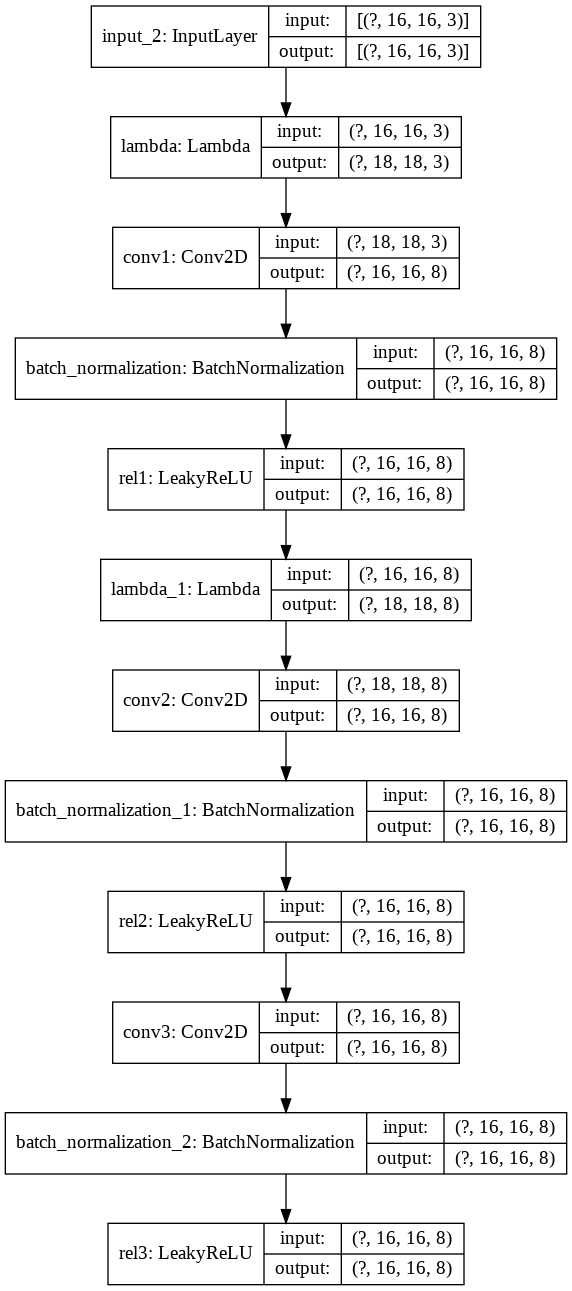

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
def join_block(input_size, n_filter_low, n_filter_high):
    input1 = tf.keras.layers.Input((input_size, input_size, n_filter_low, ))  # input to low resolution image
    input2 = tf.keras.layers.Input((2*input_size, 2*input_size, n_filter_high, ))  # input to high resolution image
    upsampled_input = tf.keras.layers.UpSampling2D(size = (2, 2))(input1)
    hidden_1 = tf.keras.layers.BatchNormalization()(upsampled_input)
    hidden_2 = tf.keras.layers.BatchNormalization()(input2)
    
    outputs = tf.keras.layers.Concatenate(axis=-1)([hidden_1, hidden_2])
    
    # final model
    join_block = tf.keras.models.Model([input1, input2], outputs)
    return join_block

In [0]:
model = join_block(128, 32, 8)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 32 0                                            
__________________________________________________________________________________________________
up_sampling2d (UpSampling2D)    (None, 256, 256, 32) 0           input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 8) 0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 256, 256, 32) 128         up_sampling2d[0][0]              
____________________________________________________________________________________________

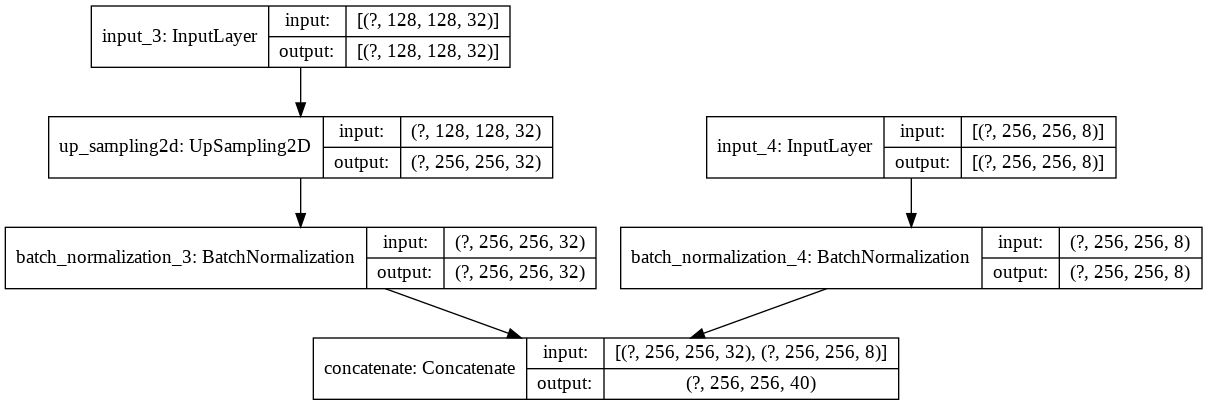

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
def generator_network():
    # create input nodes for noise tensors
    noise1 = tf.keras.layers.Input((256, 256, 3, ), name = 'noise_1')
    noise2 = tf.keras.layers.Input((128, 128, 3, ), name = 'noise_2')
    noise3 = tf.keras.layers.Input((64, 64, 3, ), name = 'noise_3')
    noise4 = tf.keras.layers.Input((32, 32, 3, ), name = 'noise_4')
    noise5 = tf.keras.layers.Input((16, 16, 3, ), name = 'noise_5')
    noise6 = tf.keras.layers.Input((8, 8, 3, ), name = 'noise_6')
    content = tf.keras.layers.Input((256, 256, 3, ), name = 'content_input')

    # downsample the content image
    content_image_8 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, tf.constant([8, 8])))(content)
    content_image_16 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, tf.constant([16, 16])))(content)
    content_image_32 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, tf.constant([32, 32])))(content)
    content_image_64 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, tf.constant([64, 64])))(content)
    content_image_128 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, tf.constant([128, 128])))(content)
    
    # create concatenation of downsampled content image and input nodes
    noise6_con = tf.keras.layers.Concatenate(axis=-1)([noise6, content_image_8])
    noise5_con = tf.keras.layers.Concatenate(axis=-1)([noise5, content_image_16])
    noise4_con = tf.keras.layers.Concatenate(axis=-1)([noise4, content_image_32])
    noise3_con = tf.keras.layers.Concatenate(axis=-1)([noise3, content_image_64])
    noise2_con = tf.keras.layers.Concatenate(axis=-1)([noise2, content_image_128])
    noise1_con = tf.keras.layers.Concatenate(axis=-1)([noise1, content])
    
    noise6_conv = conv_block(8, 6, 8)(noise6_con)   # that produces 8x8x8 tensor
    noise5_conv = conv_block(16, 6, 8)(noise5_con)   # that produces 16x16x8 tensor
    join5 = join_block(8, 8, 8)([noise6_conv, noise5_conv])   # that produces 16x16x16 tensor
    
    join5_conv = conv_block(16, 16, 16)(join5)   # produces 16x16x16 tensor
    noise4_conv = conv_block(32, 6, 8)(noise4_con)   # that produces 32x32x8 tensor
    join4 = join_block(16, 16, 8)([join5_conv, noise4_conv])   # produces 32x32x24 tensor
    
    join4_conv = conv_block(32, 24, 24)(join4)   # produces 32x32x24 tensor
    noise3_conv = conv_block(64, 6, 8)(noise3_con)  # that produces 64x64x8 tensor
    join3 = join_block(32, 24, 8)([join4_conv, noise3_conv])   # produces 64x64x32 tensor
    
    join3_conv = conv_block(64, 32, 32)(join3)   # produces 64x64x32 tensor
    noise2_conv = conv_block(128, 6, 8)(noise2_con)  # that produces 128x128x8 tensor
    join2 = join_block(64, 32, 8)([join3_conv, noise2_conv])   # produces 128x128x40 tensor
    
    join2_conv = conv_block(128, 40, 40)(join2)   # produces 128x128x40 tensor
    noise1_conv = conv_block(256, 6, 8)(noise1_con)  # that produces 256x256x8 tensor
    join1 = join_block(128, 40, 8)([join2_conv, noise1_conv])   # produces 256x256x48 tensor
    
    output = conv_block(256, 48, 3)(join1)   # produces 256x256x3 tensor
    
    model = tf.keras.models.Model([content, noise1, noise2, noise3, noise4, noise5, noise6], output, name = 'generator')
    
    return model

In [0]:
generator = generator_network()

In [0]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
content_input (InputLayer)      [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
noise_6 (InputLayer)            [(None, 8, 8, 3)]    0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 8, 8, 3)      0           content_input[0][0]              
__________________________________________________________________________________________________
noise_5 (InputLayer)            [(None, 16, 16, 3)]  0                                            
__________________________________________________________________________________________

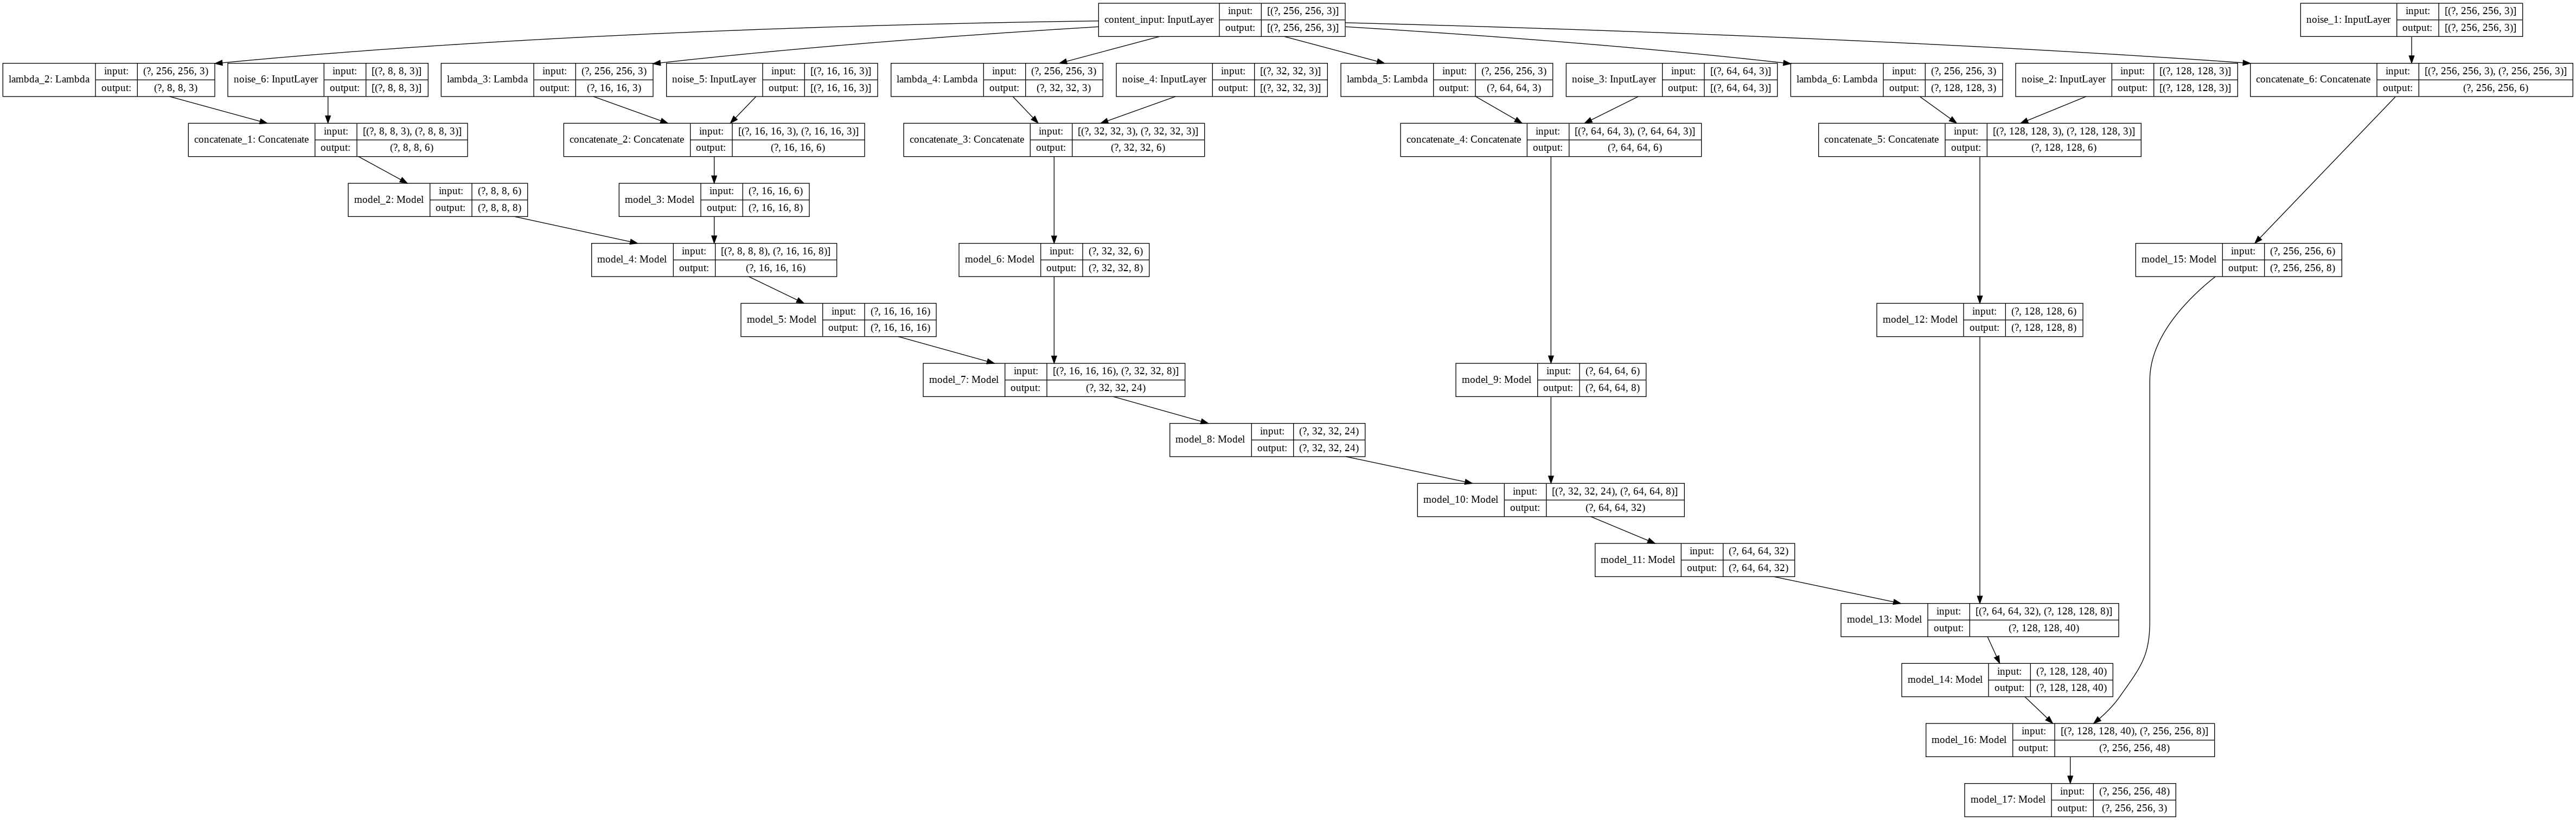

In [0]:
tf.keras.utils.plot_model(generator, show_shapes = True)

In [0]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)   # compute the sum in numerator
    input_shape = tf.shape(input_tensor)  # get the shape
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)  
    return result/(num_locations)

In [0]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')  # load the vgg model
    vgg.trainable = False    # do not train over vgg model parameters
  
    outputs = [vgg.get_layer(name).output for name in layer_names]    # the output of the layers that we want

    model = tf.keras.Model([vgg.input], outputs)   # create a keras model
    return model

In [0]:
class TextureNetwork(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(TextureNetwork, self).__init__()   # initialize the superClass
        self.vgg =  vgg_layers(style_layers + content_layers)    # obtain a VGG19 model with outputs being the style and content layers
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False  # we are not going to train vgg network

        self.gen = generator_network()   # create a generator network as part of it
        self.gen.trainable = True   # we are going to train this generator
        

    def call(self, content, batch_size = 16):
        # generates noise required for the network
        noise1 = tf.random.uniform((batch_size, 256, 256, 3))
        noise2 = tf.random.uniform((batch_size, 128, 128, 3))
        noise3 = tf.random.uniform((batch_size, 64, 64, 3))
        noise4 = tf.random.uniform((batch_size, 32, 32, 3))
        noise5 = tf.random.uniform((batch_size, 16, 16, 3))
        noise6 = tf.random.uniform((batch_size, 8, 8, 3))
    
        gen_image = self.gen([content, noise1, noise2, noise3, noise4, noise5, noise6])   # pass through the generator to obtain generated image
    
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(gen_image)  # preprocess the image
        outputs = self.vgg(preprocessed_input)  # get the output from only the required layers
        
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]  # create style type output to compare

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}


        return {'gen':gen_image, 'content':content_dict, 'style':style_dict}

In [0]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv2']
content_layers = ['block4_conv2']

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)  # use an Adam optimizer
tex_net = TextureNetwork(style_layers, content_layers)   # create the texture network

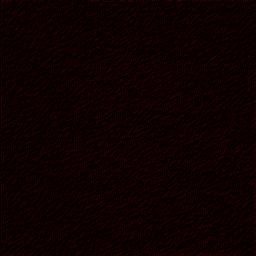

In [0]:
output = tex_net(content_image, 1)
tensor_to_image(255*output['gen'])

In [0]:
def extract_targets(inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)  # preprocess the input image
    outputs = vgg_layers(style_layers + content_layers)(preprocessed_input)  # get the output from only the required layers
        
    style_outputs, content_outputs = (outputs[:len(style_layers)], 
                                       outputs[len(style_layers):])
        
    style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]  # create style type output to compare

    style_dict = {style_name:value
                      for style_name, value
                      in zip(style_layers, style_outputs)}

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(content_layers, content_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [0]:
style_targets = extract_targets(style_image)['style']
content_targets = extract_targets(content_image)['content']

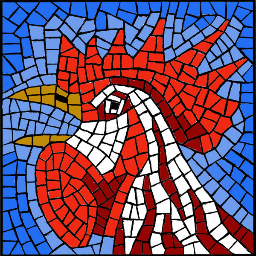

In [0]:
tensor_to_image(255*style_image)

In [0]:
style_weight = 1e-6
content_weight = 1

In [0]:
def custom_loss(outputs, batch_size):
    gen_outputs = outputs['gen']
    style_outputs = outputs['style']   # for generated image, get the style
    content_outputs = outputs['content']  # get content
    batch_loss = 0
    for i in range(batch_size):
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name][i]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
        style_loss *= style_weight / len(style_layers)

        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name][i]-content_targets[name])**2) 
                                 for name in content_outputs.keys()])
        content_loss *= content_weight / len(content_layers)
        
        loss = style_loss + content_loss
        batch_loss += loss
        
    batch_loss /= batch_size
    return batch_loss

In [0]:
@tf.function()
def train_step(content_image, batch_size):
    
    with tf.GradientTape() as tape:
        outputs = tex_net(content_image, batch_size)
        loss = custom_loss(outputs, batch_size)
        
    gradients = tape.gradient(loss, tex_net.trainable_variables)  # obtain the gradients recorded by the tape
    optimizer.apply_gradients(zip(gradients, tex_net.trainable_variables))   # apply the training rule using the gradients to modify the current value of prameters
    return output, loss

Epoch: 0
Loss:  tf.Tensor(3136438.8, shape=(), dtype=float32)
Loss:  tf.Tensor(3134464.0, shape=(), dtype=float32)
Loss:  tf.Tensor(3095875.8, shape=(), dtype=float32)
Loss:  tf.Tensor(3042178.8, shape=(), dtype=float32)
Loss:  tf.Tensor(3016114.0, shape=(), dtype=float32)
Loss:  tf.Tensor(2994913.8, shape=(), dtype=float32)
Loss:  tf.Tensor(2971915.8, shape=(), dtype=float32)
Loss:  tf.Tensor(2954901.8, shape=(), dtype=float32)
Loss:  tf.Tensor(2936441.0, shape=(), dtype=float32)
Loss:  tf.Tensor(2915904.0, shape=(), dtype=float32)
Loss:  tf.Tensor(2886810.8, shape=(), dtype=float32)
Loss:  tf.Tensor(2842270.0, shape=(), dtype=float32)
Loss:  tf.Tensor(2767848.8, shape=(), dtype=float32)
Loss:  tf.Tensor(2692932.5, shape=(), dtype=float32)
Loss:  tf.Tensor(2608095.0, shape=(), dtype=float32)
Loss:  tf.Tensor(2543275.8, shape=(), dtype=float32)
Loss:  tf.Tensor(2464186.8, shape=(), dtype=float32)
Loss:  tf.Tensor(2421690.8, shape=(), dtype=float32)
Loss:  tf.Tensor(2402052.5, shape=(),

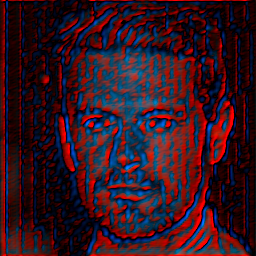

Epoch: 1
Loss:  tf.Tensor(2240344.0, shape=(), dtype=float32)
Loss:  tf.Tensor(2213531.2, shape=(), dtype=float32)
Loss:  tf.Tensor(2203295.8, shape=(), dtype=float32)
Loss:  tf.Tensor(2177552.0, shape=(), dtype=float32)
Loss:  tf.Tensor(2165774.0, shape=(), dtype=float32)
Loss:  tf.Tensor(2148687.8, shape=(), dtype=float32)
Loss:  tf.Tensor(2194286.8, shape=(), dtype=float32)
Loss:  tf.Tensor(2145039.2, shape=(), dtype=float32)
Loss:  tf.Tensor(2121859.2, shape=(), dtype=float32)
Loss:  tf.Tensor(2112110.8, shape=(), dtype=float32)
Loss:  tf.Tensor(2101757.8, shape=(), dtype=float32)
Loss:  tf.Tensor(2087807.2, shape=(), dtype=float32)
Loss:  tf.Tensor(2083123.0, shape=(), dtype=float32)
Loss:  tf.Tensor(2065946.9, shape=(), dtype=float32)
Loss:  tf.Tensor(2060737.2, shape=(), dtype=float32)
Loss:  tf.Tensor(2059365.4, shape=(), dtype=float32)
Loss:  tf.Tensor(2042328.4, shape=(), dtype=float32)
Loss:  tf.Tensor(2066709.6, shape=(), dtype=float32)
Loss:  tf.Tensor(2027177.9, shape=(),

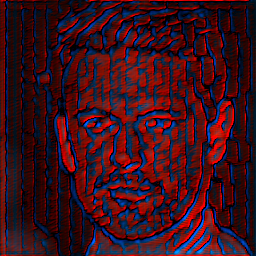

Epoch: 2
Loss:  tf.Tensor(1977007.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1973319.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1955528.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1965893.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1948800.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1937326.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1938400.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1925441.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1915692.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1922552.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1910679.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1912242.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1903795.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1901608.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1885722.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1880691.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1873997.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1883088.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1888163.2, shape=(),

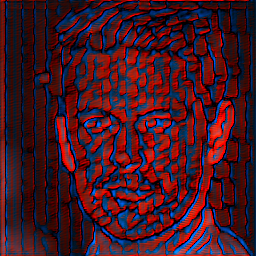

Epoch: 3
Loss:  tf.Tensor(1845449.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1834332.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1829161.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1829556.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1818631.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1818031.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1809668.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1807734.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1813307.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1800460.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1796895.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1801943.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1790742.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1796507.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1781114.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1785039.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1780203.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1774511.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1770290.0, shape=(),

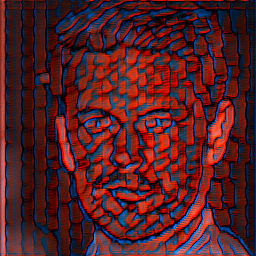

Epoch: 4
Loss:  tf.Tensor(1746147.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1741117.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1749614.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1741949.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1748611.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1741640.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1731103.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1723679.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1727342.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1718426.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1715940.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1712650.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1711975.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1707862.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1714491.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1715753.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1717983.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1700157.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1691552.0, shape=(),

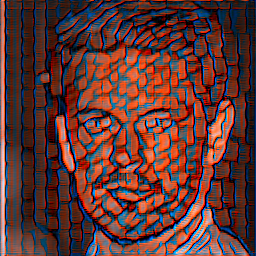

Epoch: 5
Loss:  tf.Tensor(1670753.5, shape=(), dtype=float32)
Loss:  tf.Tensor(1671560.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1665436.1, shape=(), dtype=float32)
Loss:  tf.Tensor(1670816.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1659377.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1657813.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1666263.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1653553.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1656767.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1652271.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1644063.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1643806.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1638431.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1640777.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1656311.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1651703.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1632521.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1631515.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1626188.9, shape=(),

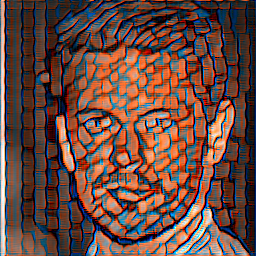

Epoch: 6
Loss:  tf.Tensor(1616851.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1613988.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1613303.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1608146.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1603829.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1603500.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1600575.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1631683.5, shape=(), dtype=float32)
Loss:  tf.Tensor(1610156.1, shape=(), dtype=float32)
Loss:  tf.Tensor(1599386.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1597686.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1591263.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1589088.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1594428.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1591427.5, shape=(), dtype=float32)
Loss:  tf.Tensor(1586879.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1584140.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1595523.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1589218.9, shape=(),

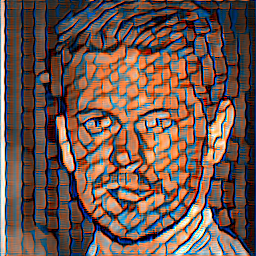

Epoch: 7
Loss:  tf.Tensor(1570768.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1570488.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1570114.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1573338.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1570386.1, shape=(), dtype=float32)
Loss:  tf.Tensor(1569279.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1565800.5, shape=(), dtype=float32)
Loss:  tf.Tensor(1573815.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1564677.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1564775.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1579184.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1573065.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1619417.1, shape=(), dtype=float32)
Loss:  tf.Tensor(1579611.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1564948.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1560948.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1554729.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1553453.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1555342.6, shape=(),

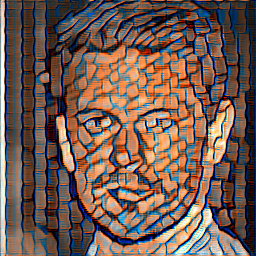

Epoch: 8
Loss:  tf.Tensor(1549960.5, shape=(), dtype=float32)
Loss:  tf.Tensor(1552043.1, shape=(), dtype=float32)
Loss:  tf.Tensor(1545692.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1555242.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1542534.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1544720.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1544281.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1542689.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1546316.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1540958.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1549139.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1539270.5, shape=(), dtype=float32)
Loss:  tf.Tensor(1540099.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1535735.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1537959.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1543230.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1537154.1, shape=(), dtype=float32)
Loss:  tf.Tensor(1533005.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1539002.9, shape=(),

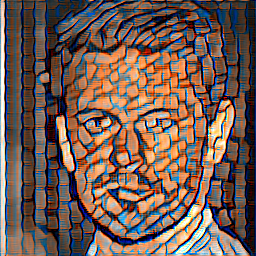

Epoch: 9
Loss:  tf.Tensor(1530194.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1525427.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1526246.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1535859.1, shape=(), dtype=float32)
Loss:  tf.Tensor(1531503.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1526849.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1525518.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1526500.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1524497.5, shape=(), dtype=float32)
Loss:  tf.Tensor(1520192.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1524880.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1522269.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1538128.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1521915.8, shape=(), dtype=float32)
Loss:  tf.Tensor(1520623.8, shape=(), dtype=float32)
Loss:  tf.Tensor(1517554.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1515368.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1521606.8, shape=(), dtype=float32)
Loss:  tf.Tensor(1517294.1, shape=(),

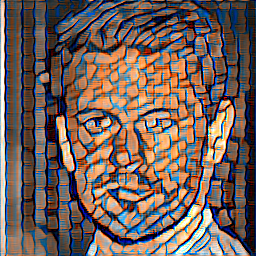

Epoch: 10
Loss:  tf.Tensor(1520609.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1510216.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1513179.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1511062.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1515841.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1519259.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1508014.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1511139.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1507296.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1523873.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1507242.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1507531.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1504013.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1511789.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1509221.5, shape=(), dtype=float32)
Loss:  tf.Tensor(1507006.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1505193.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1515428.8, shape=(), dtype=float32)
Loss:  tf.Tensor(1563715.2, shape=()

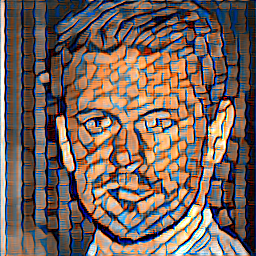

Epoch: 11
Loss:  tf.Tensor(1496804.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1496456.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1503433.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1501583.8, shape=(), dtype=float32)
Loss:  tf.Tensor(1497779.5, shape=(), dtype=float32)
Loss:  tf.Tensor(1497677.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1502977.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1501968.1, shape=(), dtype=float32)
Loss:  tf.Tensor(1493931.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1502878.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1494089.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1496488.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1507561.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1498540.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1492279.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1498571.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1507202.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1498499.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1492427.0, shape=()

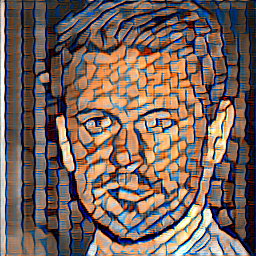

Epoch: 12
Loss:  tf.Tensor(1491869.8, shape=(), dtype=float32)
Loss:  tf.Tensor(1488183.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1489051.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1489121.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1486458.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1486133.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1484140.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1488417.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1485292.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1485662.5, shape=(), dtype=float32)
Loss:  tf.Tensor(1482358.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1491068.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1486480.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1485432.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1484641.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1482357.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1487633.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1488357.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1484225.1, shape=()

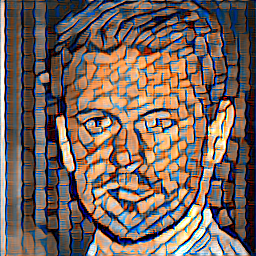

Epoch: 13
Loss:  tf.Tensor(1482511.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1479023.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1477561.5, shape=(), dtype=float32)
Loss:  tf.Tensor(1476564.8, shape=(), dtype=float32)
Loss:  tf.Tensor(1478125.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1474442.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1478579.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1477610.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1474989.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1482922.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1481708.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1475389.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1474461.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1476916.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1475750.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1476081.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1489536.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1479218.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1475674.5, shape=()

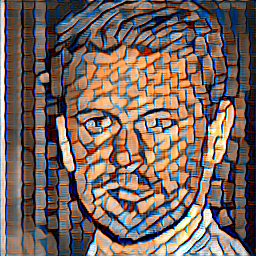

Epoch: 14
Loss:  tf.Tensor(1470746.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1469977.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1469869.8, shape=(), dtype=float32)
Loss:  tf.Tensor(1471609.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1476545.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1487026.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1472995.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1477316.0, shape=(), dtype=float32)
Loss:  tf.Tensor(1470636.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1469286.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1473416.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1476064.2, shape=(), dtype=float32)
Loss:  tf.Tensor(1470822.1, shape=(), dtype=float32)
Loss:  tf.Tensor(1469276.6, shape=(), dtype=float32)
Loss:  tf.Tensor(1467281.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1473814.4, shape=(), dtype=float32)
Loss:  tf.Tensor(1467601.8, shape=(), dtype=float32)
Loss:  tf.Tensor(1468935.9, shape=(), dtype=float32)
Loss:  tf.Tensor(1464804.0, shape=()

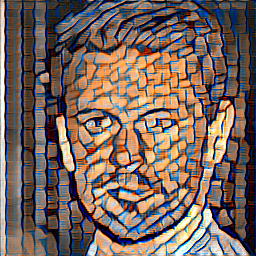

In [0]:
batch_size = 5
my_content = tf.concat([content_image for _ in range(batch_size)], axis = 0)

n_epoch = 15
n_iter = 250
iter_to_show_output = 10

loss_array = []
for epoch in range(n_epoch):
    msg = 'Epoch: ' + str(epoch)
    print(msg)
    #!'echo ' + msg
    for step in range(n_iter):
        outputs, loss = train_step(my_content, batch_size)
        if step % iter_to_show_output == 0:
            #!'echo loss: ' + str(float(loss))
            print('Loss: ', loss)
            loss_array.append(loss)
    display.display(tensor_to_image(tex_net(content_image, 1)['gen']))
    f = tensor_to_image(tex_net(content_image, 1)['gen'])
    f.save( "result_images_%d.png" % epoch)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

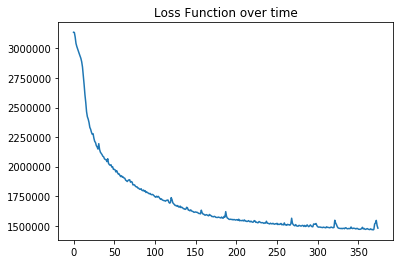

In [0]:
plt.plot(loss_array)
plt.title('Loss Function over time')
plt.show()

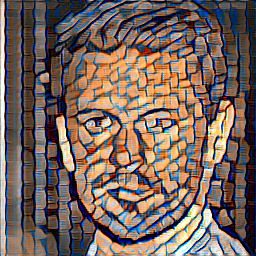

In [0]:
tensor_to_image(tex_net(content_image, 1)['gen'])